# Machine Learning with Tensorflow

Tensorflow (TF) can not only be used for deep learning, but for numerical computations in general. It is specially suited for handling matrices and tensors.

In this notebook we will explore how to use TF for *traditional* machine learning (ML) model, and how it compares to solving the same problem using a deep learning model.

In [1]:
%pylab inline
plt.style.use('seaborn-talk')
import tensorflow as tf

print(tf.__version__)

Populating the interactive namespace from numpy and matplotlib
1.11.0


## Getting familiar with Tensorflow

TF uses lazy evaluation. When we define an operation, we only create the execution graph for that operation. We need to explicitly *run* the graph to obtain the result.
* TF also supports eager execution in Python, which runs the operations inmediately, but we will not use it in this notebook
* Eager execution is intented for running small tests in an interactive notebook or prompt

In Numpy, operations occur as soon as they are written.
However, in TF we need to explicitly run the graph to obtain a result:

In [2]:
# Sum to numpy arrays
x=tf.constant(5)
y = tf.constant(8)
z = tf.multiply(x,y)
# hasta aquí definimos  el grafo, que es lazy por defecto
x

<tf.Tensor 'Const:0' shape=() dtype=int32>

In [5]:
# definimos un placeholder
p = tf.placeholder(dtype = tf.int32)
p

<tf.Tensor 'Placeholder_1:0' shape=<unknown> dtype=int32>

In [6]:
# defino una operación entre la salida de una operacion previa y el placeholder
z_p = tf.multiply(z,p)

In [3]:
# genreamos la sesión para realizar el cálculo que representa el grafo
with tf.Session() as sess:
    z_=sess.run(z)
    
z_

40

In [ ]:
# una operacion con placeholder sin alimentar da fallo
with tf.Session() as sess:
    z_p_=sess.run(z_p)
    
z_p

In [8]:
# igual alimentando el placeholder
with tf.Session() as sess:
    z_p_=sess.run(z_p, feed_dict = {p:5})
    
z_p_

200

In [ ]:
# Do the same with TF

### Exercise

To obtain the area of a triangle given the length of its sides $a$, $b$ and $c$, you can use the Formula of Heron 

$\sqrt{s(s-a)(s-b)(s-c)}$ where $\displaystyle s=\frac{a+b+c}{2}$ 

* For more context, see https://en.wikipedia.org/wiki/Heron%27s_formula

Assume that $a$, $b$ and $c$ are given as an array with 3 columns and an arbirtray number of rows, named *sides*. Each row is a possible triangle

You should write two functions that takes as inputs the arrays *sides* and returns an array with as many components as triangles, being each component the area of the corresponding triangle:
* One function using Numpy
* One function using Tensorflow. 
 *  The function should return the *tf.Tensor* without running it. The caller of the function will need to run the output afterwards to get the result
 * How do you do a square root in TF? Look up the available operations at https://www.tensorflow.org/api_docs/python/tf

In [17]:
# Solution with Numpy
def heron_np(sides):
    s = np.sum(sides, axis=1) / 2
    a,b,c = [sides[:,i] for i in range(np.size(sides,1))]
    
    return np.sqrt(s * (s-a)*(s-b)*(s-c))

In [18]:
# Check results with numpy
sides = np.array([[5, 3, 7.1],[ 2.3, 4.1, 4.8]])
print("Input triangles:")
print(sides)

print("Output with multiple rows:")
multi = heron_np(sides)
print(multi)
print("Outputs with single rows:")
a1 = heron_np(np.array([sides[0,:]]))
a2 = heron_np(np.array([sides[1,:]]))
print(a1)
print(a2)
assert np.all(multi == np.append(a1,a2))

Input triangles:
[[5.  3.  7.1]
 [2.3 4.1 4.8]]
Output with multiple rows:
[6.27849454 4.70914005]
Outputs with single rows:
[6.27849454]
[4.70914005]


In [23]:
# Solution with TF: handling tensors in TF is quite similar to handling numpy arrays
def heron_tf(sides):
    a = tf.constant(sides[:,0])
    b = tf.constant(sides[:,1])
    c = tf.constant(sides[:,2])
    s = (a + b + c)/2
    z = tf.sqrt(s * (s-a) * (s-b) * (s-c))    
    return z

In [26]:
# Check the TF solution
# nuestra función devuelve el grafo
areas_tf = heron_tf(sides)

# lo evaluamos
with tf.Session() as sess:
    areas =sess.run(areas_tf)
    
print(areas)


[6.27849454 4.70914005]


In [34]:
# pasando un placeholder
def heron_tf2(sides_ph):
    a = sides_ph[:,0]
    b = sides_ph[:,1]
    c = sides_ph[:,2]
    s = (a + b + c)/2
    z = tf.sqrt(s * (s-a) * (s-b) * (s-c))    
    return z

In [35]:
# aquí estoy definiendo el placeholder sin pasar las dimensiones (asignara la memoria dinamicamente)
mysides_ph = tf.placeholder(dtype = tf.float64)
# así se declararía de modo estático (probablemente más eficiente)
# mysides_ph = tf.placeholder(dtype = tf.float64, shape=[2,3])
areas_tf_ph = heron_tf2(mysides_ph)

#evaluacion rellenando el placeholder con feed_dict
with tf.Session() as sess:
    areas_ph = sess.run(areas_tf_ph, feed_dict = {mysides_ph:sides})
    
print(areas_ph)

[6.27849454 4.70914005]


## Our first model

For this model, we will use the following data:
* http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml

In the data subdirectory, you will find three files. We have divided the dataset in three subsets
* Training
* Validation
* Test

**Question**: Why three different sets? What will we use the validation set for? Could not we use just two subsets?

In [36]:
! ls -hl ../data/taxi*

-rw-r--r-- 1 ptardaguila 1049089  84K Nov 16 13:01 ../data/taxi-test.csv
-rw-r--r-- 1 ptardaguila 1049089 394K Nov 16 13:01 ../data/taxi-train.csv
-rw-r--r-- 1 ptardaguila 1049089  84K Nov 16 13:01 ../data/taxi-valid.csv


In [37]:
# We will use Pandas to explore the data
import pandas as pd

In [38]:
# The CSV files come without a header, let's put some names for clarity
CSV_COLUMNS = ['fare_amount', 'pickuplon','pickuplat','dropofflon','dropofflat','passengers', 'key']

In [44]:
# Read the train, validation and test data
df_train = pd.read_csv('../data/taxi-train.csv', header=None, names= CSV_COLUMNS)
df_test = pd.read_csv('../data/taxi-test.csv', header=None, names= CSV_COLUMNS)
df_valid = pd.read_csv('../data/taxi-valid.csv', header=None, names= CSV_COLUMNS)


### Transforming input data
We will train a simple linear model using tf.estimator, a higher level API of TF.

Notice that we have the data in Pandas dataframes. How can we feed a pandas dataframe to TF?

One option is converting it to tensor from the dataframe using `tf.convert_to_tensor`.

In [45]:
# Convert train, validation and test pd dataframes to tensors 
tf_train = tf.convert_to_tensor(df_train)
tf_test = tf.convert_to_tensor(df_test)
tf_valid = tf.convert_to_tensor(df_valid)

However, it is easier to keep the Pandas df info (column names, etc.) to evaluate the model later on. We can create a TF dataset from Pandas, to use with tf.estimator.

We will write a function so we can make several tests changing the number of epochs (one of the hyperaparemeters)

In [83]:
# Use tf.estimator.inputs.pandas_input_fn to create a TF dataset from Pandas

# queue capacity: la cola es un almacén de datos que TF usa para preprocesar (almacenar en forma de tensores) los datos que irán a los batches, que son placeholders que van alimentados con los tensores de la cola. La construccion de la  cola depende de las epochs que queramos usar para entrenar el modelo posteriormente
def pandas2tf(df, epochs):
    tf_dataset = tf.estimator.inputs.pandas_input_fn(
        x= df,
        y = df.fare_amount, # predictando
        shuffle = True,
        queue_capacity=1000 # mil samples en la cola
    )
    
    return tf_dataset 

In [49]:
tf_train = pandas2tf(df_train, 1)
tf_valid = pandas2tf(df_valid, 1)
tf_test = pandas2tf(df_test, 1)

### Feature columns

For the model, we need to select the feature columns. We will use all columns, except the *key* one, which is just an index.

Also, the first column is in fact the target variable that we will predict, so we will remove it from the features too.

In [54]:
# Define feature_cols using tf.feature_column.numeric_column
feature_cols = [tf.feature_column.numeric_column(c) for c in CSV_COLUMNS[1:-1]]

### Training the model

In [58]:
tf.logging.set_verbosity(tf.logging.INFO)

import shutil
# WARNING!!!! THIS DIRECTORY WILL BE REMOVED, DON'T PUT ANYTHING THERE
OUTDIR = 'taxi_trained'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time

In [59]:
# Linear Regression model using tf.estimator.LinearRegressor
# No tenemos que identificar el predictando porque lo hicimos al definir el tensor dataset
# con que alimentamos el modelo
linear_model = tf.estimator.LinearRegressor(
    feature_columns= feature_cols,
    model_dir=OUTDIR
)

linear_model.train(tf_train)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'taxi_trained', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000000EF9E780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, u

### Evaluate the model

Is this model good? How can we interpret the average loss in the evaluation metrics dict? What's the *physical meaning* of that number?

In [61]:
# Evaluate the model with the help of the validation set
metrics = linear_model.evaluate(tf_valid)
metrics

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-17-09:58:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from taxi_trained\model.ckpt-58
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-17-09:58:37
INFO:tensorflow:Saving dict for global step 58: average_loss = 94.50939, global_step = 58, label/mean = 11.340872, loss = 11421.096, prediction/mean = 11.286898
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 58: taxi_trained\model.ckpt-58


{'average_loss': 94.50939,
 'label/mean': 11.340872,
 'loss': 11421.096,
 'prediction/mean': 11.286898,
 'global_step': 58}

#### Question

What is the average loss if we use the tf_train with evaluate? Is it correct to use those numbers to evaluate the model?

### Exercise: plot the average loss for the training and validation datasets, over the num. of epochs

What is the impact of the number of epochs in the results of the model?

Repeat the training process with epochs ranging from 1 to 10, and plot the *average_loss* for the training and validation datasets.
* What conclusions can you extract from that plot?

In [73]:
tf.logging.set_verbosity(tf.logging.ERROR)
OUTDIR = 'taxi_trained'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time
    
def train_for_epochs(nepochs):
    
    tf_train = pandas2tf(df_train, nepochs)
    tf_valid = pandas2tf(df_valid, nepochs)
    
    model = tf.estimator.LinearRegressor(
        feature_columns=feature_cols,
        model_dir=OUTDIR
    )
    
    model.train(tf_train)
    train_loss = model.evaluate(tf_train)['average_loss']
    valid_loss = model.evaluate(tf_valid)['average_loss']
    print('train_loss=', train_loss, 'valid_loss=',valid_loss)
    return train_loss, valid_loss

Training with 1 epochs...
train_loss= 102.61062 valid_loss= 97.07974
Training with 2 epochs...
train_loss= 100.056946 valid_loss= 94.77326
Training with 3 epochs...
train_loss= 101.02687 valid_loss= 95.811104
Training with 4 epochs...
train_loss= 100.0869 valid_loss= 94.79156
Training with 5 epochs...
train_loss= 99.841805 valid_loss= 94.47963
Training with 6 epochs...
train_loss= 100.64336 valid_loss= 95.16749
Training with 7 epochs...
train_loss= 99.89654 valid_loss= 94.49731
Training with 8 epochs...
train_loss= 99.94281 valid_loss= 94.532104
Training with 9 epochs...
train_loss= 99.85027 valid_loss= 94.48968
Training with 10 epochs...
train_loss= 100.43906 valid_loss= 95.1605


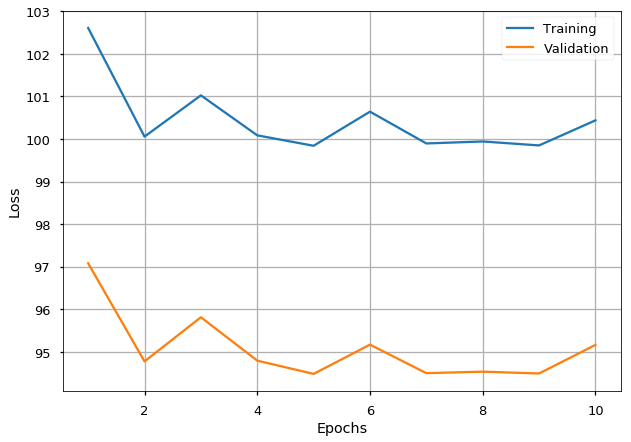

In [74]:
# Plot the results
epochs = np.arange(1,11)
train_loss = []
valid_loss = []
for e in epochs:
    print("Training with %d epochs..." % e)
    t, v = train_for_epochs(e)
    train_loss.append(t)
    valid_loss.append(v)
    
plt.figure(figsize=(10,7))
plt.plot(epochs, train_loss, label='Training')
plt.plot(epochs, valid_loss, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

So the model does not look exceptionally good. This is normal, we have just tried a linear model without any kind of feature engineering or transformation; we don't know for instance if the relationship between *fare_amount* and the rest of features is linear or not.

Let's try another simple model using TF, but this one will be more complex

## A more complex model

We are going to reuse a lot of code from the previous model, we will just change the kind of estimator we are using.

Let's repeat the same estimator again, and we will run it for 20 epochs this time. Then we will compare it with the new one:

In [84]:
# Si usamos la funcion creada con queue_capacity=1000 probablemente falle a partir de un determinado numero de epochs. Redefinimos con una cola  mayor
def pandas2tf(df, epochs):
    tf_dataset = tf.estimator.inputs.pandas_input_fn(
        x= df,
        y = df.fare_amount, # predictando
        shuffle = True,
        queue_capacity=5000 # mil samples en la cola
    )
    
    return tf_dataset 

In [85]:

def train_for_epochs_dl(nepochs):
    
    tf_train = pandas2tf(df_train, nepochs)
    tf_valid = pandas2tf(df_valid, nepochs)
    
    model = tf.estimator.DNNRegressor(
        feature_columns=feature_cols,
        model_dir=OUTDIR,
        hidden_units=[32,8,2] # dimensión de las capas ocultas: estamos metiendo una expansion y luego compresion del problema (receta tipica en aproximacion de modelos lineales)
    )
    
    model.train(tf_train)
    train_loss = model.evaluate(tf_train)['average_loss']
    valid_loss = model.evaluate(tf_valid)['average_loss']
    print('train_loss=', train_loss, 'valid_loss=',valid_loss)
    return train_loss, valid_loss

Training with 1 epochs...
train_loss= 214.11267 valid_loss= 207.50415
Training with 2 epochs...
train_loss= 207.6938 valid_loss= 201.12323
Training with 3 epochs...
train_loss= 202.93489 valid_loss= 196.39322
Training with 4 epochs...
train_loss= 199.044 valid_loss= 192.52646
Training with 5 epochs...
train_loss= 195.69977 valid_loss= 189.20328
Training with 6 epochs...
train_loss= 192.74055 valid_loss= 186.26312
Training with 7 epochs...
train_loss= 190.07668 valid_loss= 183.61656
Training with 8 epochs...
train_loss= 187.64488 valid_loss= 181.2008
Training with 9 epochs...
train_loss= 185.40202 valid_loss= 178.97295
Training with 10 epochs...
train_loss= 183.31728 valid_loss= 176.90234
Training with 11 epochs...
train_loss= 181.36714 valid_loss= 174.96556
Training with 12 epochs...
train_loss= 179.53426 valid_loss= 173.14542
Training with 13 epochs...
train_loss= 177.80324 valid_loss= 171.42656
Training with 14 epochs...
train_loss= 176.16249 valid_loss= 169.79744
Training with 15 ep

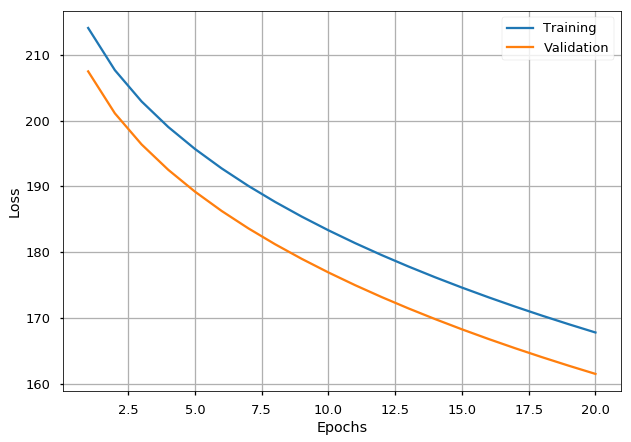

In [86]:
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time
# Plot the results
epochs = np.arange(1,21)
train_dl_loss = []
valid_dl_loss = []
for e in epochs:
    print("Training with %d epochs..." % e)
    t, v = train_for_epochs_dl(e)
    train_dl_loss.append(t)
    valid_dl_loss.append(v)
    
plt.figure(figsize=(10,7))
plt.plot(epochs, train_dl_loss, label='Training')
plt.plot(epochs, valid_dl_loss, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

NameError: name 'train_dl_loss' is not defined

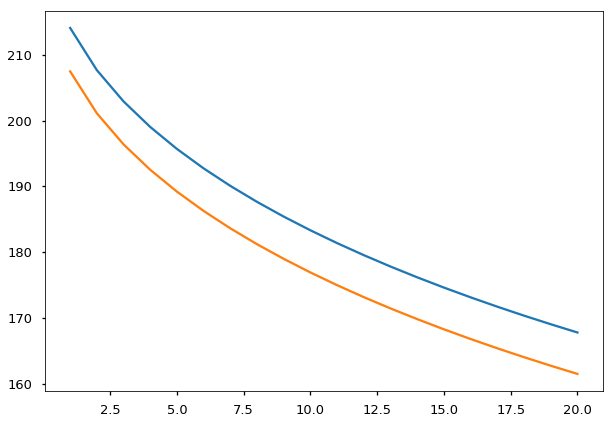

In [87]:
plt.figure(figsize=(10,7))
plt.plot(epochs, train_loss, label='Training (linear)')
plt.plot(epochs, valid_loss, label='Validation (linear)')
plt.plot(epochs, train_dl_loss, label='Training (DL)')
plt.plot(epochs, valid_dl_loss, label='Validation (DL)')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()

Is this new model better? Why does not the linear model change with the number of epochs?

What would you do next to improve the Deep Learning model?
* Possible answers: increase the number of epochs, maybe try a more complex model. Any other hyperparam?

Let's try with 150 epochs, and see if we can beat the training and validation loss

In [88]:
tf_train = pandas2tf(df_train,70)
tf_valid = pandas2tf(df_valid, 70)
tf_test = pandas2tf(df_test, 70)

shutil.rmtree(OUTDIR, ignore_errors=True)

linear_model = tf.estimator.LinearRegressor(feature_columns=feature_cols, model_dir=OUTDIR)
linear_model.evaluate(tf_test)

{'average_loss': 213.31387,
 'label/mean': 11.104378,
 'loss': 25794.57,
 'prediction/mean': 0.0,
 'global_step': 0}

In [89]:
shutil.rmtree(OUTDIR, ignore_errors=True)

linear_model = tf.estimator.DNNRegressor(feature_columns=feature_cols, model_dir=OUTDIR, hidden_units=[32,8,2])
linear_model.evaluate(tf_test)

{'average_loss': 149.41762,
 'label/mean': 11.104377,
 'loss': 18068.04,
 'prediction/mean': 3.3964365,
 'global_step': 0}

## Final decision about the models

So far, we have been ignoring the test set. We have used the validation dataset to change the hyperparameters of the model. It is now the turn to use the test set to finally decide which model is better: the linear regressor or the neural network.

For this, we can retrain the models using both the train and validation sets, with the hyperparameters that we have already decided. Then we will evaluate both models using only the test set, and we will find out which one is better predicting the test set, that is, a set of data that has not been used in any way to tune the model (the validation set has been used to tune the hyperparams, so somehow the validation set info is already included in the model).

In [ ]:
# Evaluate the LinearRegressor model

In [ ]:
# Evaluate tf.estimator.DNNRegressor model